# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [ ]:
import json
import os
import csv
import urllib
from io import BytesIO
import PIL
from PIL import Image
import re

from socket import timeout

from google.colab import files

!pip3 install -q torch torchvision
!pip3 install -q Pillow

Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [ ]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

--2021-08-09 16:28:57--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M  28.1MB/s    in 19s     

2021-08-09 16:29:17 (27.6 MB/s) - ‘train.zip’ saved [562348083/562348083]

Number of files in the train folder 4603
--2021-08-09 16:29:22--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

tes

In [ ]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

In [ ]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.folder))
    
    def __getitem__(self, index):       
        if torch.is_tensor(index):
          index = index.to_list()

        img_file = os.listdir(self.folder)[index]
        img_name = os.path.join(self.folder, img_file)
        img = Image.open(img_name)

        pos_labels = ['frankfurter', 'chill-dog', 'hotdog']
        y = 0
        for label in pos_labels:
          if label in img_file:
            y = 1

        img_id = re.findall(r'\d+', img_file)

        if self.transform:
          img = self.transform(img)

        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1, count, i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   

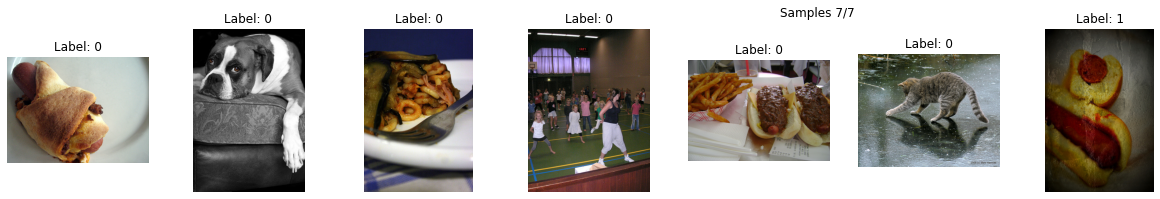

In [ ]:
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

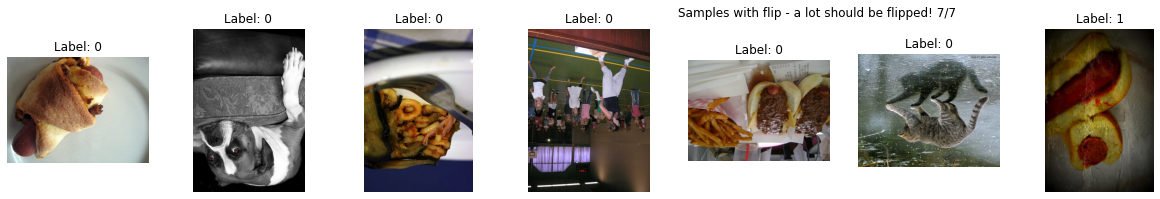

In [ ]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [ ]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/vision/stable/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/vision/stable/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [ ]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

In [ ]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    
    correct = 0
    total = 0
    for x, y, _ in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)

        preds = torch.argmax(model(x_gpu), 1)
        correct += torch.sum(preds == y_gpu)
        total += y.shape[0]
    
    return correct / total

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, _) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

In [ ]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
    
model = models.resnet18(pretrained=True)
model.type(torch.cuda.FloatTensor)
model.to(device)

model.eval()

classes = load_imagenet_classes()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
def visualize_predictions(model, train_dataset, orig_dataset, indices, classes, title=None, count=10):
  plt.figure(figsize=(count * 3, 3))
  for i, idx in enumerate(indices):
    x, _, _ = train_dataset[idx]
    x_gpu = x.to(device)

    preds = torch.argmax(model(torch.unsqueeze(x_gpu, 0)), 1)

    plt.subplot(1, 10, i + 1)
    plt.title(f'Label: {classes[float(preds)]}')
    plt.imshow(orig_dataset[idx][0])
    plt.grid(False)
    plt.axis('off')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


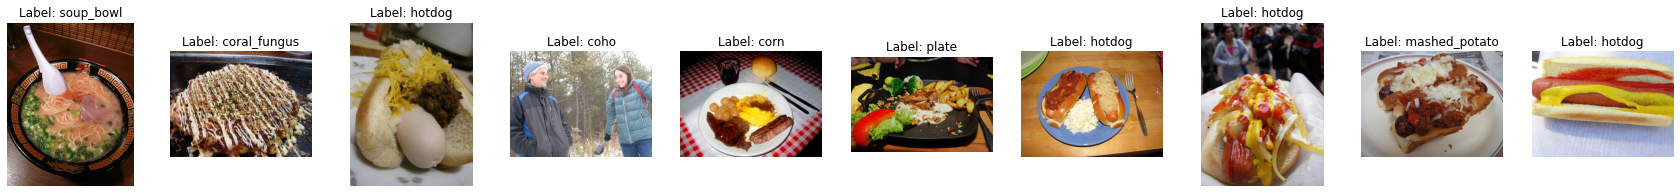

In [ ]:
rand_indices = np.random.choice(range(len(train_dataset)), size=10, replace=False)
visualize_predictions(model, train_dataset, orig_dataset, rand_indices, classes)

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 0.386579, Train accuracy: 0.828944, Val accuracy: 0.875000
Average loss: 0.277299, Train accuracy: 0.877545, Val accuracy: 0.893478


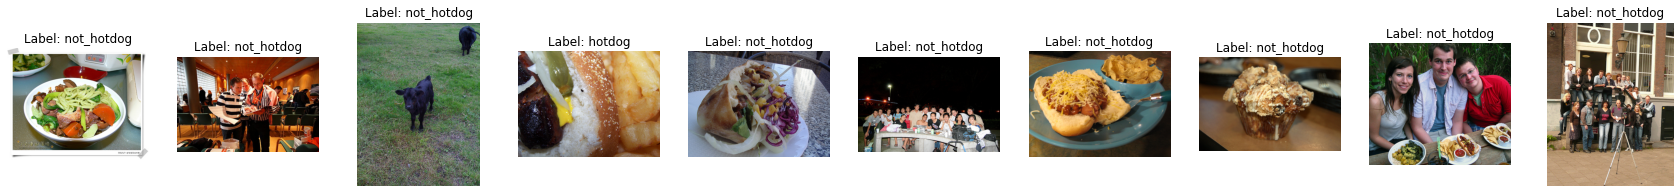

In [ ]:
classes = {0: 'not_hotdog', 1: 'hotdog'}
rand_indices = np.random.choice(range(len(train_dataset)), size=10, replace=False)
visualize_predictions(model, train_dataset, orig_dataset, rand_indices, classes)

# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последгний слой на новый и обучать всю модель целиком.

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.337463, Train accuracy: 0.842791, Val accuracy: 0.889130
Average loss: 0.212998, Train accuracy: 0.912571, Val accuracy: 0.914130
Average loss: 0.164592, Train accuracy: 0.933207, Val accuracy: 0.908696
Average loss: 0.128675, Train accuracy: 0.950312, Val accuracy: 0.910870
Average loss: 0.102590, Train accuracy: 0.966332, Val accuracy: 0.906522


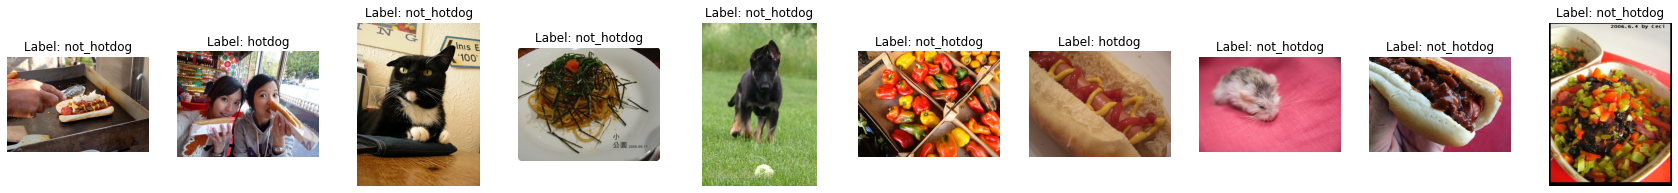

In [ ]:
classes = {0: 'not_hotdog', 1: 'hotdog'}
rand_indices = np.random.choice(range(len(train_dataset)), size=10, replace=False)
visualize_predictions(model, train_dataset, orig_dataset, rand_indices, classes)

# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer
# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model = model.to(device)

fc_params = model.fc.parameters()
not_fc_params = [param for name, param in model.named_parameters() if not name.startswith('fc.')]

loss = nn.CrossEntropyLoss()
# Hint - look into what PyTorch optimizers let you configure!
optimizer = optim.SGD([{'params': fc_params, 'lr': 0.001}, {'params': not_fc_params, 'lr': 0.0001}],
                      momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.392008, Train accuracy: 0.823513, Val accuracy: 0.872826
Average loss: 0.263713, Train accuracy: 0.881618, Val accuracy: 0.891304
Average loss: 0.246431, Train accuracy: 0.892479, Val accuracy: 0.900000
Average loss: 0.229743, Train accuracy: 0.900896, Val accuracy: 0.909783
Average loss: 0.216119, Train accuracy: 0.912300, Val accuracy: 0.909783


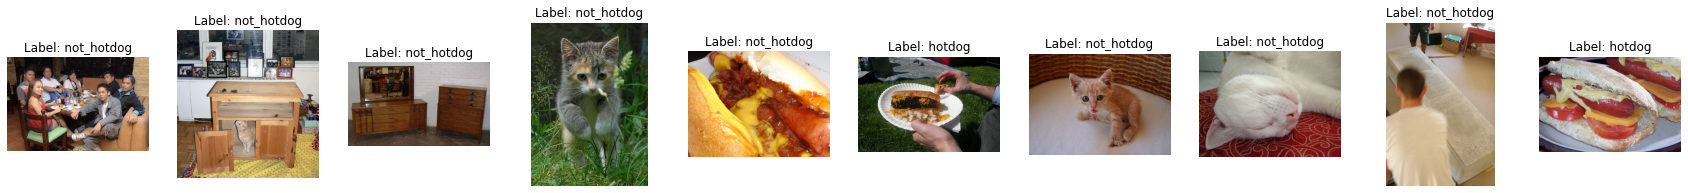

In [ ]:
classes = {0: 'not_hotdog', 1: 'hotdog'}
rand_indices = np.random.choice(range(len(train_dataset)), size=10, replace=False)
visualize_predictions(model, train_dataset, orig_dataset, rand_indices, classes)

# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [ ]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetSampler(indices))
    
    predictions = []
    ground_truth = []
    for x, y, _ in loader:
        x_gpu = x.to(device)
        y_gpu = x.to(device)
        predictions += torch.argmax(model(x_gpu), 1).tolist()
        ground_truth += y.tolist()
    
    return np.array(predictions), np.array(ground_truth)

In [ ]:
predictions, gt = evaluate_model(model, train_dataset, val_indices)

И теперь можно визуализировать false positives и false negatives.

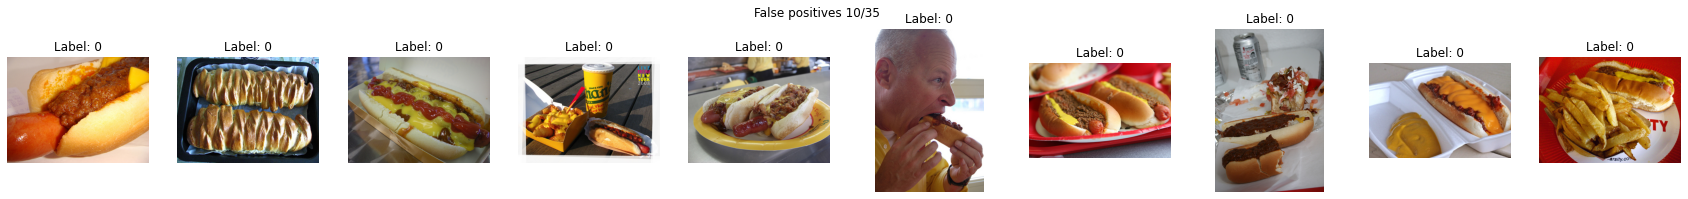

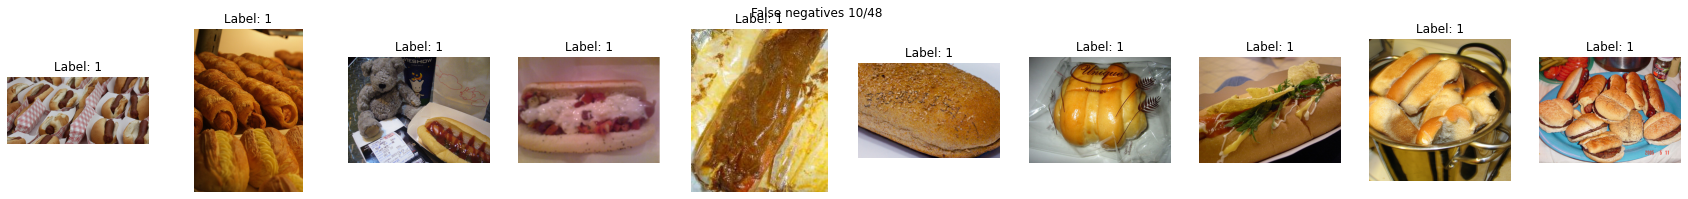

In [ ]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive = np.nonzero((predictions == 1) & (gt == 0))
false_positive_indices = np.array(val_indices)[false_positive]
visualize_samples(orig_dataset, false_positive_indices, "False positives")

# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives = np.nonzero((predictions == 0) & (gt == 1))
false_negatives_indices = np.array(val_indices)[false_negatives]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")


In [ ]:
import sklearn.metrics as metrics
def binary_classification_metrics(prediction, ground_truth):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for (pred, true) in zip(prediction, ground_truth):
        if pred == True and true == True: tp += 1
        elif pred == True and true == False: fp += 1
        elif pred == False and true == False: tn += 1
        elif pred == False and true == True: fn += 1
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.765, P: 0.794, R: 0.738


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

In [ ]:
def compute_accuracy_f1(model, loader):
    """
    Computes accuracy and f1 score on the dataset wrapped in a loader
    
    Returns: accuracy and f1 score as a float values between 0 and 1
    """
    model.eval()
    
    correct = 0
    total = 0
    tp, fp, tn, fn = 0, 0, 0, 0
    for x, y, _ in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)

        preds = torch.argmax(model(x_gpu), 1)

        preds = preds.cpu().numpy()
        gt = y.cpu().numpy()

        tp += float(np.sum((preds == 1) & (gt == 1)))
        fp += float(np.sum((preds == 1) & (gt == 0)))
        tn += float(np.sum((preds == 0) & (gt == 0)))
        fn += float(np.sum((preds == 0) & (gt == 1)))

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    try:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * precision * recall / (precision + recall)
    except:
      f1 = 0
    
    return accuracy, f1

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    val_f1_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, _) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy, val_f1 = compute_accuracy_f1(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        val_f1_history.append(val_f1)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f, Val f1-score: %f" % (ave_loss, train_accuracy, val_accuracy, val_f1))
        
    return loss_history, train_history, val_history, val_f1_history

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model = model.to(device)

fc_params = model.fc.parameters()
not_fc_params = [param for name, param in model.named_parameters() if not name.startswith('fc.')]

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD([{'params': fc_params, 'lr': 0.001}, {'params': not_fc_params, 'lr': 0.0001}],
                      momentum=0.9)
loss_history, train_history, val_history, val_f1_history = train_model(model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 0.417651, Train accuracy: 0.810752, Val accuracy: 0.880435, Val f1-score: 0.730392
Average loss: 0.279144, Train accuracy: 0.871844, Val accuracy: 0.896739, Val f1-score: 0.714715
Average loss: 0.253663, Train accuracy: 0.893837, Val accuracy: 0.907609, Val f1-score: 0.755043
Average loss: 0.228480, Train accuracy: 0.901168, Val accuracy: 0.897826, Val f1-score: 0.765000
Average loss: 0.213182, Train accuracy: 0.912843, Val accuracy: 0.896739, Val f1-score: 0.700315
Average loss: 0.204220, Train accuracy: 0.912028, Val accuracy: 0.908696, Val f1-score: 0.751479
Average loss: 0.190595, Train accuracy: 0.919088, Val accuracy: 0.904348, Val f1-score: 0.731707
Average loss: 0.191546, Train accuracy: 0.920445, Val accuracy: 0.913043, Val f1-score: 0.782609
Average loss: 0.174169, Train accuracy: 0.932935, Val accuracy: 0.913043, Val f1-score: 0.780220
Average loss: 0.170961, Train accuracy: 0.929677, Val accuracy: 0.905435, Val f1-score: 0.754930


## Аугментации

In [ ]:
train_aug_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.RandomHorizontalFlip(p=0.4),
                           transforms.RandomVerticalFlip(p=0.3),
                           transforms.ColorJitter(saturation=.2, hue=.2),
                           transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
train_aug_dataset_for_vis = HotdogOrNotDataset(train_folder, 
                              transform=transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(p=0.4),
                                transforms.RandomVerticalFlip(p=0.3),
                                transforms.ColorJitter(saturation=.2, hue=.2),
                                transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),                        
                              ])
                            )
train_aug_loader = torch.utils.data.DataLoader(train_aug_dataset, 
                                               batch_size=batch_size, 
                                               sampler=train_sampler)
train_aug_loader_for_vis = torch.utils.data.DataLoader(train_aug_dataset_for_vis,
                                                       batch_size=batch_size,
                                                       sampler=train_sampler) 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


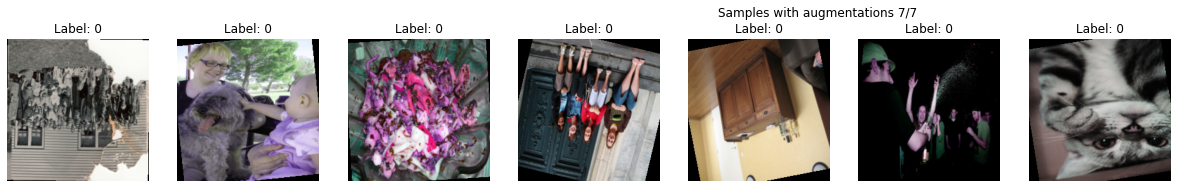

In [ ]:
rand_indices = np.random.choice(np.arange(len(train_aug_dataset_for_vis)), 7, replace=False)
visualize_samples(train_aug_dataset_for_vis, rand_indices, 'Samples with augmentations')

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model = model.to(device)

fc_params = model.fc.parameters()
not_fc_params = [param for name, param in model.named_parameters() if not name.startswith('fc.')]

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD([{'params': not_fc_params, 'lr': 0.0001}, {'params': fc_params, 'lr': 0.001}],
                      momentum=0.9)
loss_history, train_history, val_history, val_f1_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 0.428020, Train accuracy: 0.814010, Val accuracy: 0.868478, Val f1-score: 0.685714
Average loss: 0.316708, Train accuracy: 0.854738, Val accuracy: 0.885870, Val f1-score: 0.728682
Average loss: 0.285969, Train accuracy: 0.869943, Val accuracy: 0.886957, Val f1-score: 0.737374
Average loss: 0.276934, Train accuracy: 0.879175, Val accuracy: 0.900000, Val f1-score: 0.747253
Average loss: 0.267049, Train accuracy: 0.883790, Val accuracy: 0.898913, Val f1-score: 0.757180
Average loss: 0.273029, Train accuracy: 0.882976, Val accuracy: 0.903261, Val f1-score: 0.757493
Average loss: 0.257381, Train accuracy: 0.892479, Val accuracy: 0.904348, Val f1-score: 0.768421
Average loss: 0.239898, Train accuracy: 0.895737, Val accuracy: 0.901087, Val f1-score: 0.745098
Average loss: 0.243177, Train accuracy: 0.893294, Val accuracy: 0.903261, Val f1-score: 0.770026
Average loss: 0.252890, Train accuracy: 0.895194, Val accuracy: 0.901087, Val f1-score: 0.742210


## Подбор гипперпараметров

In [ ]:
from collections import namedtuple

In [ ]:
Hyperparams = namedtuple("Hyperparams", ['learning_rates_old', 'learning_rates_new', 'reg_strengths'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy', 'val_f1_history', 'final_val_f1'])

learning_rates_old = [1e-2, 1e-3, 1e-4]
learning_rates_new = [1e-2, 1e-3, 1e-4]
reg_strengths = [1e-3, 1e-4, 1e-5, 1e-6]

batch_size = 64
epoch_num = 10

run_record = {}

def param_search(run_record, learning_rates_old, learning_rates_new, reg_strengths, num_epochs=10):
  for lr_old in learning_rates_old:
    for lr_new in learning_rates_new:
      for reg in reg_strengths:
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
        model.type(torch.cuda.FloatTensor)
        model = model.to(device)

        fc_params = model.fc.parameters()
        not_fc_params = [param for name, param in model.named_parameters() if not name.startswith('fc.')]

        loss = nn.CrossEntropyLoss()
        optimizer = optim.SGD([{'params': not_fc_params, 'lr': lr_old}, {'params': fc_params, 'lr': lr_new}],
                              momentum=0.9,
                              weight_decay=reg)
        print(f'lr_old: {lr_old}, lr_new: {lr_new}, reg: {reg}')
        loss_history, train_history, val_history, val_f1_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, num_epochs)

        params = Hyperparams(lr_old, lr_new, reg)
        run_results = RunResult(model, train_history, val_history, val_history[-1], val_f1_history, val_f1_history[-1])
        run_record[params] = run_results

        print('\n\n')

In [ ]:
param_search(run_record, learning_rates_old, learning_rates_old, reg_strengths)

lr_old: 0.01, lr_new: 0.01, reg: 0.001
Average loss: 0.475393, Train accuracy: 0.826772, Val accuracy: 0.860870, Val f1-score: 0.507692
Average loss: 0.250956, Train accuracy: 0.888678, Val accuracy: 0.901087, Val f1-score: 0.752044
Average loss: 0.208990, Train accuracy: 0.907684, Val accuracy: 0.884783, Val f1-score: 0.725389
Average loss: 0.179045, Train accuracy: 0.928591, Val accuracy: 0.902174, Val f1-score: 0.761905
Average loss: 0.174421, Train accuracy: 0.927233, Val accuracy: 0.893478, Val f1-score: 0.736559
Average loss: 0.165056, Train accuracy: 0.936465, Val accuracy: 0.890217, Val f1-score: 0.671010
Average loss: 0.155097, Train accuracy: 0.936465, Val accuracy: 0.895652, Val f1-score: 0.705521
Average loss: 0.135999, Train accuracy: 0.944339, Val accuracy: 0.880435, Val f1-score: 0.715026
Average loss: 0.127007, Train accuracy: 0.952213, Val accuracy: 0.889130, Val f1-score: 0.648276
Average loss: 0.125733, Train accuracy: 0.951398, Val accuracy: 0.893478, Val f1-score: 

In [ ]:
# TODO: Train your best model!
best_model = None

In [ ]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (precision, recall, f1))

# TODO: Visualize training curve for the best model

## Визуализируйте ошибки лучшей модели

In [ ]:
# TODO Visualize false positives and false negatives of the best model on the validation set

# Необязательное задание с большой звездочкой

Поучавствуйте в Kaggle In-Class Hot Dog Recognition Challenge!  
Это соревнование сделано специально для курса и в нем учавствуют только те, кто проходит курс.

В нем участники соревнуются в качестве натренированных моделей, загружая на сайт предсказания своих моделей на тестовой выборке. Разметка тестовой выборке участникам недоступна.
Более подробно о правилах соревнования ниже.

Те, кто проходят курс лично, за высокое место в соревновании получат дополнительные баллы.

Здесь уже можно использовать и другие базовые архитектуры кроме `resnet18`, и ансамбли, и другие трюки тренировки моделей.

Вот ссылка на соревнование:
https://www.kaggle.com/c/hotdogornot

In [ ]:
image_id = []
predictions = []
model.eval()
for x,_,id_img in test_loader:
    # TODO : Напишите код для предсказания меток (1 = есть хотдог, 0 = хотдога нет)
    # Код должен возвратить список из id картинки и метку predictions
    # image id - это название файла картинки, например '10000.jpg'
    pass

In [ ]:
# Так можно создать csv файл, чтобы затем загрузить его на kaggle
# Ожидаемый формат csv-файла:
# image_id,label
# 10000.jpg,1
# 10001.jpg,1
# 10002.jpg,0
# 10003.jpg,1
# 10004.jpg,0

with open('subm.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_id,predictions))

In [ ]:
# А так можно скачать файл с Google Colab
files.download('subm.csv') 

### Небольшое введение в Kaggle для тех, кто не слышал об этой платформе раньше

В основе своей Kaggle - это платформа для проведения соревнований по машинному обучению. Появилась она в 2010 и, пожалуй, стала самой популярной и известной из всех существующих площадок по машинному обучению. Надо сказать, что Kaggle - это не только соревнования, но и сообщество людей, увлеченных машинным обучением. А судя по Википедии, в 2017 году отметка зарегистрированных пользователей перевалила за миллион. Есть там и обучающие материалы, возможность задавать вопросы, делиться кодом и идеями - просто мечта. 

### Как проходят соревнования? 
Обычно участники скачивают данные для обучения моделей (train data), чтобы затем делать предсказания на тестовых данных (test data). Обучающая выборка содержит как сами данные, так и правильные метки (значения зависимой переменной), чтобы можно было обучить модель. Но тестовые данные ответа не содержат - и нашей целью является предсказание меток по имеющимся данным. Файл с ответами для каждого наблюдения из тестовой выборки загружается на Kaggle и оценивается в соответствии с выбранной метрикой соревнования, а результат является публичным и показывается в общей таблице (ее называют еще лидербордом - leaderboard) - чтобы появилось желание посоревноваться и создать еще более сильную модель. В "настоящих" соревнованиях, которые проходят на Kaggle, есть и денежное вознаграждение для тех участников, кто занимает первые места на лидерборде. Например, в [этом](https://www.kaggle.com/c/zillow-prize-1#description) соревновании, человек, занявший первое место, получил около 1 000 000 долларов. 

Тестовые данные делятся случайным образом в некоторой пропорции. И пока соревнование идет, на лидерборде показываются очки и рейтинг участников только по одной части (Public Leaderboard). А вот когда соревнование заканчивается, то рейтинг участников составляется по второй части тестовых данных (Private Leaderboard). И часто можно видеть, как люди занимавшие первые места на публичной части тестовых данных, оказываются далеко не первыми на закрытой части тестовых данных. Зачем это сделано? Есть несколько причин, но, пожалуй, самой фундаментальной является идея недообучения-переобучения. Всегда возможно, что наша модель настроилась на конкретную выборку, но как она поведет себя на тех данных, которые еще не видела? Разбиение тестовых данных на публичную и скрытую части сделано для того, чтобы отобрать модели, которые имеют большую обобщающую способность. Одним из лозунгов участников соревнований стал "Доверяйте своей локальной кросс-валидации" (Trust your CV!). Есть очень большой соблазн оценивать свою модель по публичной части лидерборда, но лучшей стратегией будет выбирать ту модель, которая дает лучшую метрику на кросс-валидации на обучающей выборке. 

В нашем соревновании публичная часть лидерборда составляет 30%, а скрытая 70%. Вы можете делать до двух попыток в день, а оцениваться попытки будут по F1-мере. Удачи и доверяйте своей локальной валидации! В конце соревнования у вас будет возможность выбрать 2 из всех совершенных попыток - лучшая из этих двух и будет засчитана вам на скрытой части тестовых данных.